In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../../')

In [2]:
import torch
from src.models.ecg_step_module import EcgEmbed
from src.basic.dx_and_feat import Feature, zero_vec

N = 64 # batch_size
batched_ecg = torch.rand(N, 12, 5000)
batched_feat = zero_vec(Feature, [N])
batched_input = (batched_ecg, batched_feat)
all_mid_output = {'pipeline': {}}
embed = EcgEmbed(all_mid_output)(batched_input)
print(all_mid_output['EcgEmbed']['embed'].shape)

torch.Size([64, 240])


In [3]:
# from torch import nn
# from pmlayer.torch.hierarchical_lattice_layer import HLattice

# output_layer = nn.Linear(64, 1)
# consequent_model = nn.Sequential(self.embed_layer, output_layer)
# HLattice(263, sizes, self.lattice_inc_indices, consequent_model)

In [4]:
from src.models.ecg_step_module import BlockModule
# all_mid_output['BlockModule'].clear()
block_module = BlockModule(all_mid_output)
# print(block_module)
block_module(batched_input)

{'feat': tensor(0., grad_fn=<BinaryCrossEntropyBackward0>),
 'delta': tensor([0.], grad_fn=<AddBackward0>)}

In [5]:
print(all_mid_output['BlockModule']['LPR_imp'].shape)
print(all_mid_output['BlockModule']['LQRS_imp'].shape)
print(all_mid_output['BlockModule']['AVB'].shape)
print(all_mid_output['BlockModule']['LBBB'].shape)
print(all_mid_output['BlockModule']['RBBB'].shape)

torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])


In [23]:
from src.basic.rule_ml import SeqSteps
from src.models.ecg_step_module import EcgEmbed, BlockModule
from src.basic.dx_and_feat import Feature, zero_vec

N = 64 # batch_size
batched_ecg = torch.rand(N, 12, 5000)
batched_feat = zero_vec(Feature, [N])
batched_input = (batched_ecg, batched_feat)
all_mid_output = {}

# test SeqSteps
seq1 = SeqSteps('seq1', all_mid_output, [EcgEmbed(all_mid_output), BlockModule(all_mid_output)])
losses = seq1(batched_input)
print(losses)

<class 'dict'>
<class 'dict'>
<class 'dict'>
(0, 0)


In [34]:
from src.basic.rule_ml import PipelineModule
from src.basic.dx_and_feat import Diagnosis
y = torch.zeros([N, len(Diagnosis)], dtype=torch.float32)
batch = (batched_input, y)
# test PipelineModule
pipeline_module = PipelineModule()
all_mid_output = pipeline_module.all_mid_output
seq2 = SeqSteps('seq2', all_mid_output, [EcgEmbed(all_mid_output), BlockModule(all_mid_output)])
pipeline_module.add_pipeline(seq2)
losses = pipeline_module.training_step(batch, 0)
print(losses)

tensor(0.1047, grad_fn=<AddBackward0>)


## Test Trainer

In [ ]:

# training params
max_epochs = 50
save_top_k = 5

# Define hyperparameters here

# model with suggested hyperparameters
pipeline_module = get_default_pipeline()
trainer = Trainer(
    callbacks=get_trainer_callbacks(trial, save_top_k),
    #   limit_train_batches=4,
    #   limit_val_batches=4,
    #   limit_test_batches=4,
    max_epochs=max_epochs,
    accelerator="auto",
    logger=pl_loggers.TensorBoardLogger(save_dir=save_dir),
    log_every_n_steps=LOG_INTERVAL,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
    enable_progress_bar=False)

# record hyperparameters
# hyperparams = dict(num_of_naive_net_layers=num_of_naive_net_layers, naive_net_output_dims=naive_net_output_dims)
# trainer.logger.log_hyperparams(hyperparams)
trainer.fit(pipeline_module, data_module)

return trainer.callback_metrics["val_epoch/total_loss"].item()

## Test Trained Model

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../../')

In [2]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from src.models.ecg_step_module import EcgPipeline
from src.utils.data_utils import EcgDataModule
from src.utils.train_utils import get_common_trainer_params, set_cuda_env
from src.basic.constants import BEST_MODEL_PATH

save_dir = BEST_MODEL_PATH
ckpt_name = 'MPAV_rho8-auroc=0.8360216.ckpt'
ckpt_path = os.path.join(save_dir, ckpt_name)

model = EcgPipeline.load_from_checkpoint(ckpt_path)

In [51]:
t = torch.tensor([2.331, 1.536, 0.772, 0.532])
print(t / t.sum())

tensor([0.4508, 0.2970, 0.1493, 0.1029])


In [49]:
print(model.IMI_ensemble.weight)

Parameter containing:
tensor([[-1.3310, -1.5362, -0.2229, -0.8359]], requires_grad=True)


In [6]:
agg_path = os.path.join(save_dir, 'MPAV_rho8_val_mid_output_agg.csv')
model.generate_report(agg_path, 9)

In [7]:
from src.utils.data_utils import EcgDataModule
ecg_data_module = EcgDataModule()
train_ds, val_ds, test_ds = ecg_data_module.load_ds_with_feat()

['SR', 'AMI']


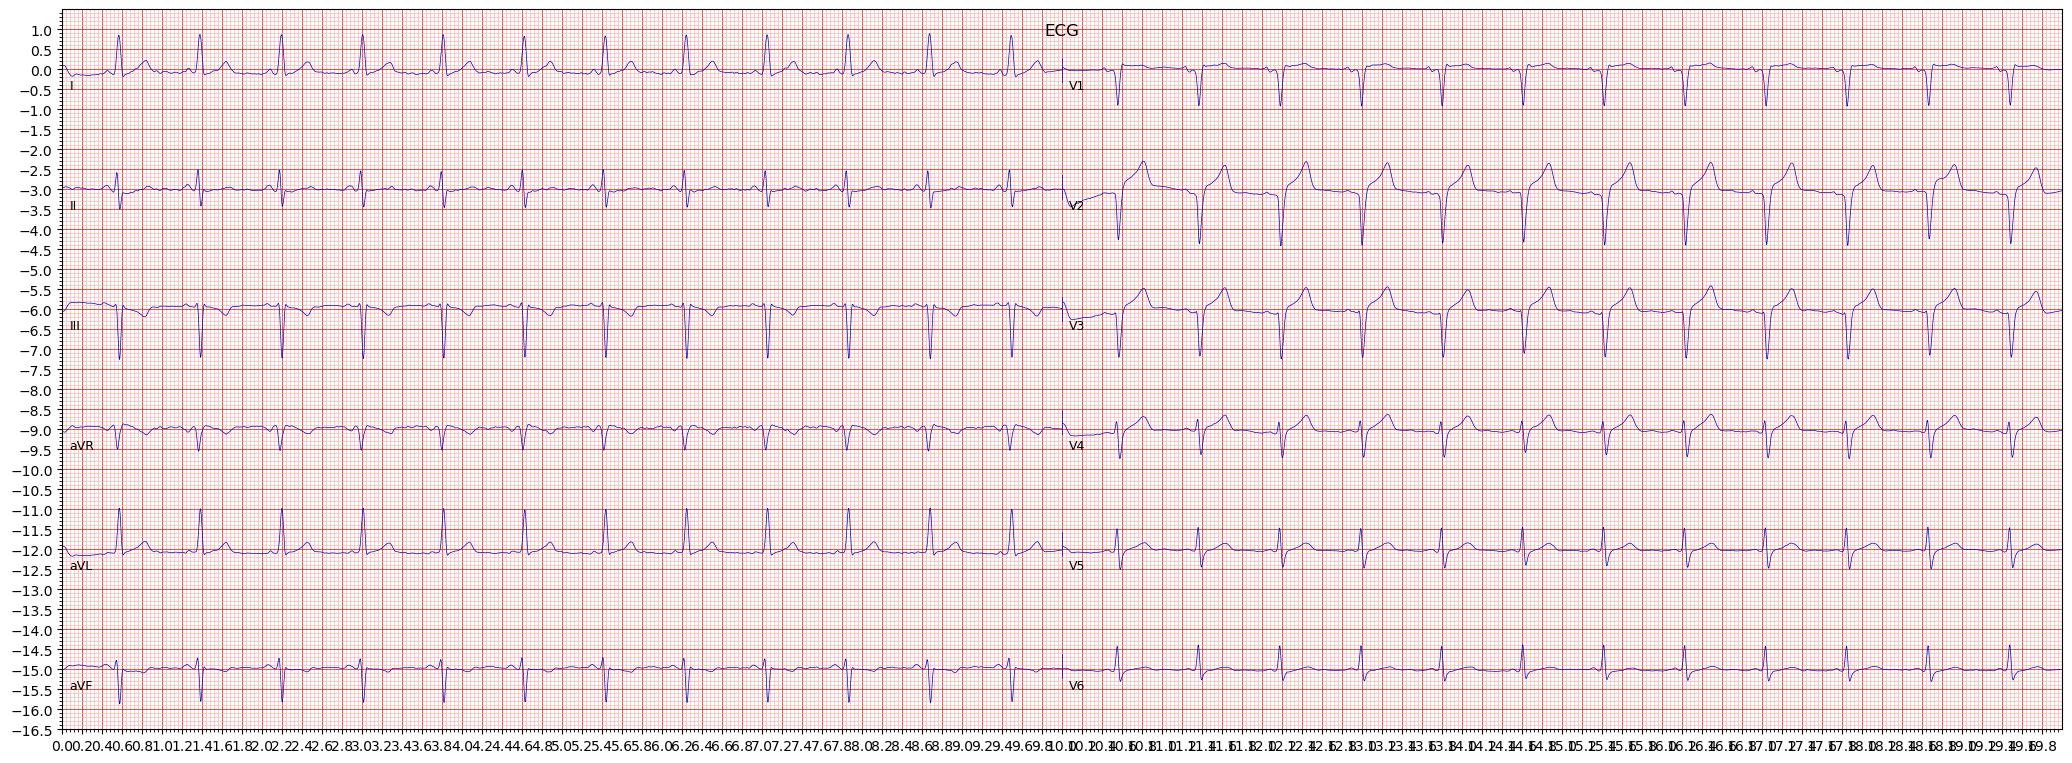

In [16]:
from src.basic.ecg import Ecg
ecg: Ecg = test_ds.find_ecg_with_diagnosis('AMI', 13)
print(ecg.str_diagnoses)
ecg.show_with_grid()

In [56]:
ecg.HR

71.83125

In [68]:
index = test_ds.signals.index(ecg)
model.generate_report(agg_path, index)

In [28]:
import torch
from src.basic.rule_ml import Or, And, StepModule
step = StepModule('step', {})
GOR = Or(step, 2)
AND = And(step)
OR = Or(step, 1)

# STModule's impression for STE_II is 0.311 STModule's impression for STE_III is 0.415 STModule's impression for STE_aVR is 0.431 STModule's impression for STE_aVL is 0.298 STModule's impression for STE_aVF is 0.299 STModule's impression for STE_V1 is 0.718 STModule's impression for STE_V2 is 0.868 STModule's impression for STE_V3 is 0.799 STModule's impression for STE_V4 is 0.641 STModule's impression for STE_V5 is 0.253 STModule's impression for STE_V6 is 0.254
STE_I = torch.tensor([0.283])
STE_II = torch.tensor([0.311])
STE_III = torch.tensor([0.415])
STE_aVR = torch.tensor([0.431])
STE_aVL = torch.tensor([0.298])
STE_aVF = torch.tensor([0.299])
STE_V1 = torch.tensor([0.718])
STE_V2 = torch.tensor([0.868])
STE_V3 = torch.tensor([0.799])
STE_V4 = torch.tensor([0.641])
STE_V5 = torch.tensor([0.253])
STE_V6 = torch.tensor([0.254])

# GOR_2(STE_II, STE_III, STE_aVF)
GOR([STE_II, STE_III, STE_aVF])

tensor([0.5125])

In [29]:
# (STE_V1 ∧ STE_V2) ∨ (STE_V2 ∧ STE_V3) ∨ ... ∨ (STE_V5 ∧ STE_V6)

OR([AND([STE_V1, STE_V2]), AND([STE_V2, STE_V3]), AND([STE_V3, STE_V4]), AND([STE_V4, STE_V5]), AND([STE_V5, STE_V6])])

tensor([1.])

In [31]:
# GOR_2(STE_I, STE_aVL, STE_V5, STE_V6)
GOR([STE_I, STE_aVL, STE_V5, STE_V6])

tensor([0.5440])

In [32]:
# for STD_I is 0.636 for STD_II is 0.605 for STD_III is 0.353 for STD_aVR is 0.282 for STD_aVL is 0.378 for STD_aVF is 0.371 for STD_V1 is 0.237 for STD_V2 is 0.113 for STD_V3 is 0.276 for STD_V4 is 0.242 for STD_V5 is 0.296 for STD_V6 is 0.201
STD_I = torch.tensor([0.636])
STD_II = torch.tensor([0.605])
STD_III = torch.tensor([0.353])
STD_aVR = torch.tensor([0.282])
STD_aVL = torch.tensor([0.378])
STD_aVF = torch.tensor([0.371])
STD_V1 = torch.tensor([0.237])
STD_V2 = torch.tensor([0.113])
STD_V3 = torch.tensor([0.276])
STD_V4 = torch.tensor([0.242])
STD_V5 = torch.tensor([0.296])
STD_V6 = torch.tensor([0.201])

# GOR_2(STD_II, STD_III, STD_aVF) 
GOR([STD_II, STD_III, STD_aVF])

tensor([0.6645])

In [35]:
# GOR_2(STD_II, STD_III, STD_aVF) 
GOR([STD_II, STD_III, STD_aVF])

tensor([0.6645])

In [36]:
# STD_V5 ∨ STD_V6 
OR([STD_V5, STD_V6])

tensor([0.4970])

In [37]:
# STD_V1 ∧ STD_V2 ∧ STD_V3
AND([STD_V1, STD_V2, STD_V3])

tensor([0.])

In [52]:
# QRModule's impression for PATH_Q_I is 0.231
# QRModule's impression for PATH_Q_II is 0.254
# QRModule's impression for PATH_Q_III is 0.106
# QRModule's impression for PATH_Q_aVR is 0.303
# QRModule's impression for PATH_Q_aVL is 0.170
# QRModule's impression for PATH_Q_aVF is 0.342
# QRModule's impression for PATH_Q_V1 is 0.587
# QRModule's impression for PATH_Q_V2 is 0.465
# QRModule's impression for PATH_Q_V3 is 0.292
# QRModule's impression for PATH_Q_V4 is 0.158
# QRModule's impression for PATH_Q_V5 is 0.236
# QRModule's impression for PATH_Q_V6 is 0.194
PATH_Q_I = torch.tensor([0.231])
PATH_Q_II = torch.tensor([0.254])
PATH_Q_III = torch.tensor([0.106])
PATH_Q_aVR = torch.tensor([0.303])
PATH_Q_aVL = torch.tensor([0.170])
PATH_Q_aVF = torch.tensor([0.342])
PATH_Q_V1 = torch.tensor([0.587])
PATH_Q_V2 = torch.tensor([0.465])
PATH_Q_V3 = torch.tensor([0.292])
PATH_Q_V4 = torch.tensor([0.158])
PATH_Q_V5 = torch.tensor([0.236])
PATH_Q_V6 = torch.tensor([0.194])

# GOR_2(PATH_Q_II, PATH_Q_III, PATH_Q_aVF) 
GOR([PATH_Q_II, PATH_Q_III, PATH_Q_aVF])

tensor([0.3510])

In [53]:
# ATH_Q_V1 ∧ PATH_Q_V2 ∧ PATH_Q_V3 ∧ PATH_Q_V4
AND([PATH_Q_V1, PATH_Q_V2, PATH_Q_V3, PATH_Q_V4])

tensor([0.])

In [54]:
# GOR_2(PATH_Q_I, PATH_Q_aVL, PATH_Q_V5, PATH_Q_V6)
GOR([PATH_Q_I, PATH_Q_aVL, PATH_Q_V5, PATH_Q_V6])

tensor([0.4155])

In [55]:
# PModule's impression for PEAK_P_II is 0.157
# PModule's impression for PEAK_P_V1 is 0.266
PEAK_P_II = torch.tensor([0.157])
PEAK_P_V1 = torch.tensor([0.266])
# PEAK_P_II ∨ PEAK_P_V1
OR([PEAK_P_II, PEAK_P_V1])

tensor([0.4230])